# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

## 0. Import Requirements

In [1227]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily, Hourly
import datetime
import seaborn as sns
import torch
import torch.nn as nn
from copy import deepcopy as dc
import holidays
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## 1. Data Exploration

In [1228]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/new_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [1229]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      3782 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [1230]:
visitor_data.describe()

,value
count,3782.000000
mean,2.870968
std,3.526116
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,20.000000


<Axes: xlabel='timestemp'>

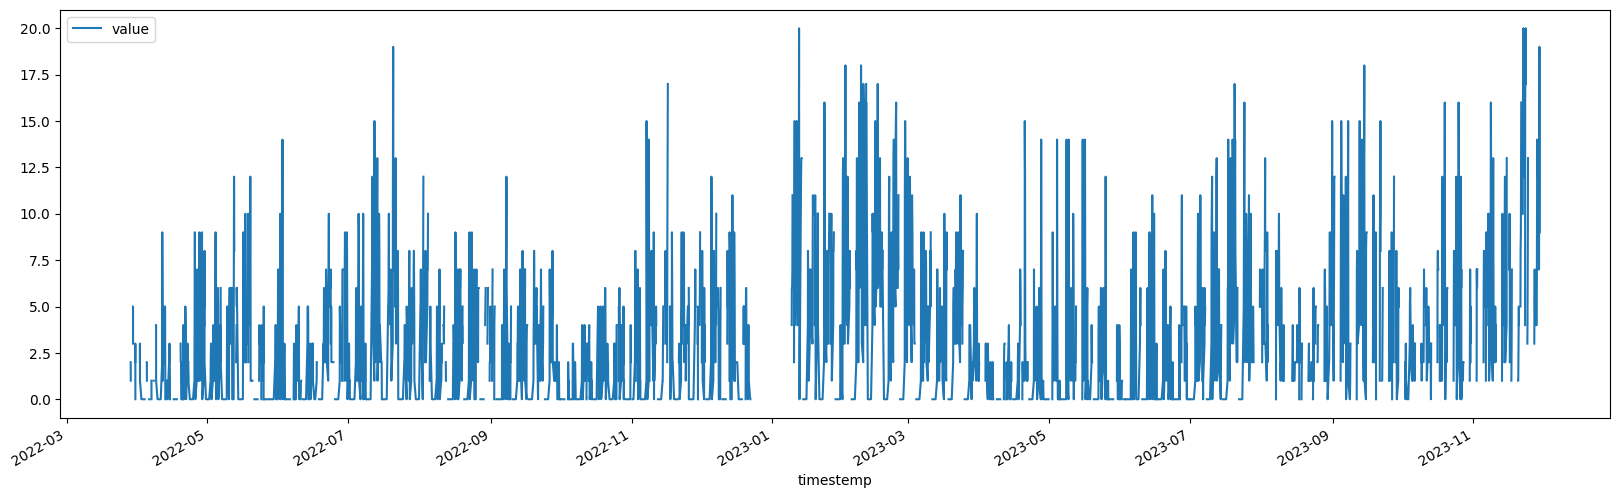

In [1231]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 2. Data Preprocessing

- Missing Values
- Sequenz der Vergangenheitswerte
- Datum extrahieren
- Wochentag anhand des Datums herausfinden
- Wochentag oder Wochenende?
    - alle Wocheendtage = 0
- Prüfungsphase hinzufügen
- Holiday/Ferien/Feiertage
- Wetterdaten

In [1232]:
# Missing Values Handling
visitor_data['value'] = visitor_data['value'].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)

<Axes: xlabel='timestemp'>

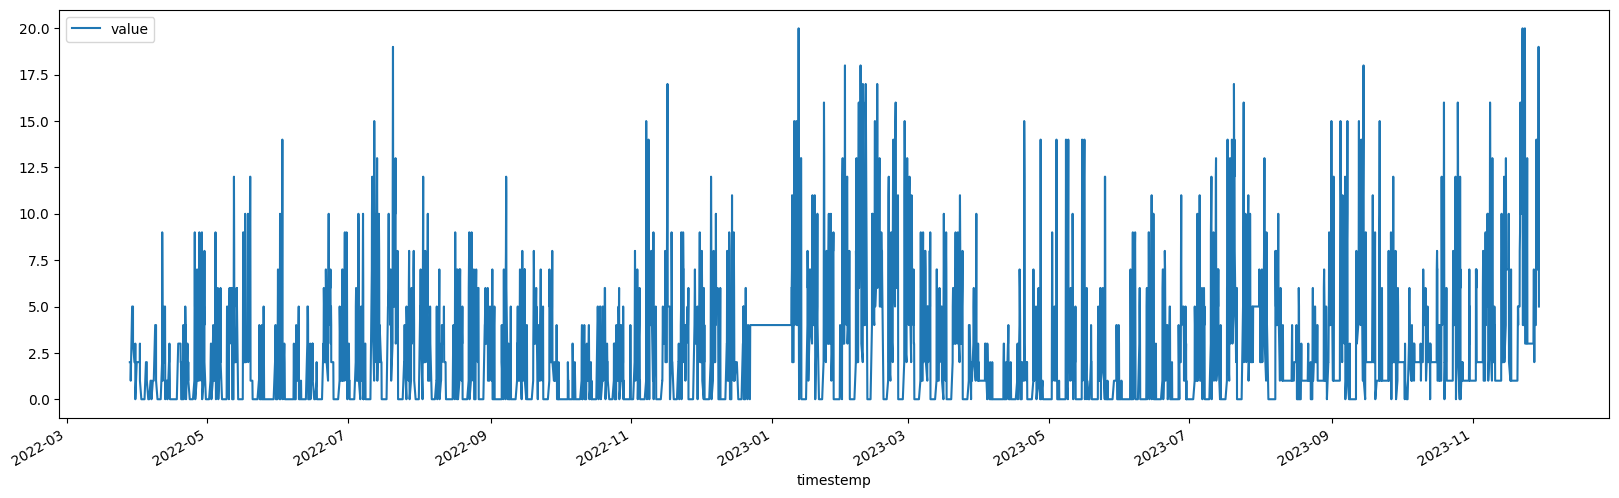

In [1233]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

In [1234]:
# Die Vergangeheitswerte t-1 etc. bekommen
def prepare_dateframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps + 1):
        df[f'value (t-{i})'] = df['value'].shift(i)

    return df

lookback = 7 # Hier rumspielen
visitor_data = prepare_dateframe_for_lstm(visitor_data, lookback)
#visitor_data

# wenn wir zwei Wochen übergeben wollen, müssen wir 8*14=114 Werte zurück gehen...

In [1235]:
# das Datum extrahieren
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list

#visitor_data

In [1236]:
# add column "weekday"
visitor_data["weekday"] = [weekday for weekday in visitor_data["timestemp"].dt.dayofweek]
#visitor_data

In [1237]:
# Check if weekday or weekend
weekend_list = []

for timestemp in visitor_data['weekday']:
    if timestemp == 5 or timestemp == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

visitor_data['weekend'] = weekend_list
#visitor_data

In [1238]:
# Set all values, where weekend day is 1 to 0
visitor_data.loc[visitor_data['weekend'].eq(1), 'value'] = 0
#visitor_data[["value", "weekend"]]

In [1239]:
# Vorlesungspahse = 0, Pfürungsphase = 1
exam_phase_ws_2021_begin = datetime.datetime(2022, 2, 10)
exam_phase_ws_2021_end = datetime.datetime(2022, 3, 31)

exam_phase_ss_2022_begin = datetime.datetime(2022, 7, 20)
exam_phase_ss_2022_end = datetime.datetime(2022, 9, 30)

exam_phase_ws_2022_begin = datetime.datetime(2023, 2, 10)
exam_phase_ws_2022_end = datetime.datetime(2023, 3, 31)

exam_phase_ss_2023_begin = datetime.datetime(2023, 7, 20)
exam_phase_ss_2023_end = datetime.datetime(2023, 9, 30)

exam_phase_ws_2023_begin = datetime.datetime(2024, 2, 10)
exam_phase_ws_2023_end = datetime.datetime(2024, 3, 31)

In [1240]:
# Exam Phase
# exam phase == 1, lecture phase == 0

exam_phase_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= exam_phase_ws_2021_begin and timestemp <= exam_phase_ws_2021_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2022_begin and timestemp <= exam_phase_ss_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2022_begin and timestemp <= exam_phase_ws_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2023_begin and timestemp <= exam_phase_ss_2023_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2023_begin and timestemp <= exam_phase_ws_2023_end:
        exam_phase_list.append(1)
    else:
        exam_phase_list.append(0)

exam_phase_list

visitor_data['exam_phase'] = exam_phase_list
# visitor_data

In [1241]:
# Check if holiday, or not; holiday = 1, else = 0

de_holidays = holidays.country_holidays('DE', subdiv='BW')

holiday_array = []

for date in visitor_data['date']:
    if date in de_holidays:
        holiday_array.append(1)
    else:
        holiday_array.append(0)

visitor_data['holiday'] = holiday_array

visitor_data.loc[visitor_data['holiday'].eq(1), 'value'] = 0

# visitor_data

In [1242]:
# Set the values of the winter vacations to 0, and holiday to 1

# We should do it for other vacations as well

wv_begin_2022 = datetime.datetime(2022, 12, 23)
wv_end_2022 = datetime.datetime(2023, 1, 8)

wv_begin_2023 = datetime.datetime(2023, 12, 23)
wv_end_2023 = datetime.datetime(2024, 1, 7)

wv_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= wv_begin_2022 and timestemp <= wv_end_2022:
        wv_list.append(1)
    elif timestemp >= wv_begin_2023 and timestemp <= wv_end_2023:
        wv_list.append(1)
    else:
        wv_list.append(0)

visitor_data['winter_vacation'] = wv_list

visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'value'] = 0
visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'holiday'] = 1

In [1243]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])

# get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-29,10.3,8.5,12.8,1.7,0.0,225.0,13.7,36.0,1016.7,167.0
2023-12-30,9.0,5.6,11.5,0.0,0.0,210.0,11.2,42.8,1017.0,194.0
2023-12-31,6.4,3.5,9.4,0.4,0.0,176.0,15.1,51.1,1008.8,1.0


In [1244]:
# weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
# plt.show()

<Axes: xlabel='timestemp'>

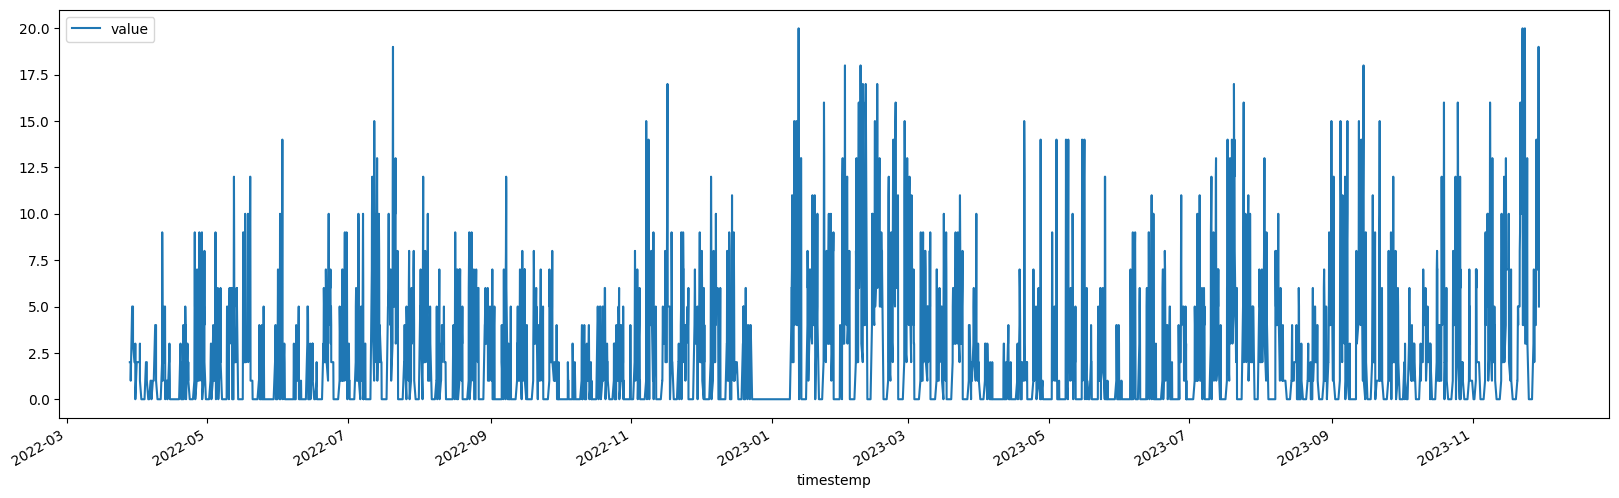

In [1245]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

In [1246]:
# merge data frames
visitor_data = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time"
)

visitor_data

,timestemp,value,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),value (t-7),date,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-03-28 09:30:00,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
1,2022-03-28 10:45:00,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2,2022-03-28 13:45:00,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
3,2022-03-28 16:15:00,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
4,2022-03-28 17:45:00,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2022-03-28,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2023-11-29 16:15:00,19.0,19.0,7.0,7.0,7.0,11.0,11.0,12.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4892,2023-11-29 17:45:00,9.0,19.0,19.0,7.0,7.0,7.0,11.0,11.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4893,2023-11-29 18:00:00,5.0,9.0,19.0,19.0,7.0,7.0,7.0,11.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4894,2023-11-29 18:30:00,5.0,5.0,9.0,19.0,19.0,7.0,7.0,7.0,2023-11-29,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0


In [1247]:
visitor_data.set_index('timestemp', inplace=True)
visitor_data

,value,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),value (t-7),date,weekday,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-03-28 09:30:00,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 10:45:00,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 13:45:00,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 16:15:00,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-28 17:45:00,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2022-03-28,0,...,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 16:15:00,19.0,19.0,7.0,7.0,7.0,11.0,11.0,12.0,2023-11-29,2,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
2023-11-29 17:45:00,9.0,19.0,19.0,7.0,7.0,7.0,11.0,11.0,2023-11-29,2,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
2023-11-29 18:00:00,5.0,9.0,19.0,19.0,7.0,7.0,7.0,11.0,2023-11-29,2,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0


In [1248]:
#calculate correlations between all features of your data frame (see Exploration lab)
data_corr = visitor_data.corr()
print(data_corr)

                    value  value (t-1)  value (t-2)  value (t-3)  value (t-4)  \
value            1.000000     0.725118     0.508755     0.352323     0.280900   
value (t-1)      0.725118     1.000000     0.750107     0.529325     0.369926   
value (t-2)      0.508755     0.750107     1.000000     0.750079     0.529269   
value (t-3)      0.352323     0.529325     0.750079     1.000000     0.750121   
value (t-4)      0.280900     0.369926     0.529269     0.750121     1.000000   
value (t-5)      0.271435     0.297393     0.370152     0.529918     0.750343   
value (t-6)      0.345274     0.289083     0.297428     0.370381     0.529482   
value (t-7)      0.438442     0.364755     0.288949     0.297297     0.370052   
weekday         -0.412039    -0.363240    -0.338586    -0.307233    -0.268954   
weekend         -0.456426    -0.408479    -0.396739    -0.384163    -0.370855   
exam_phase       0.128339     0.112463     0.114562     0.116797     0.119515   
holiday         -0.170090   

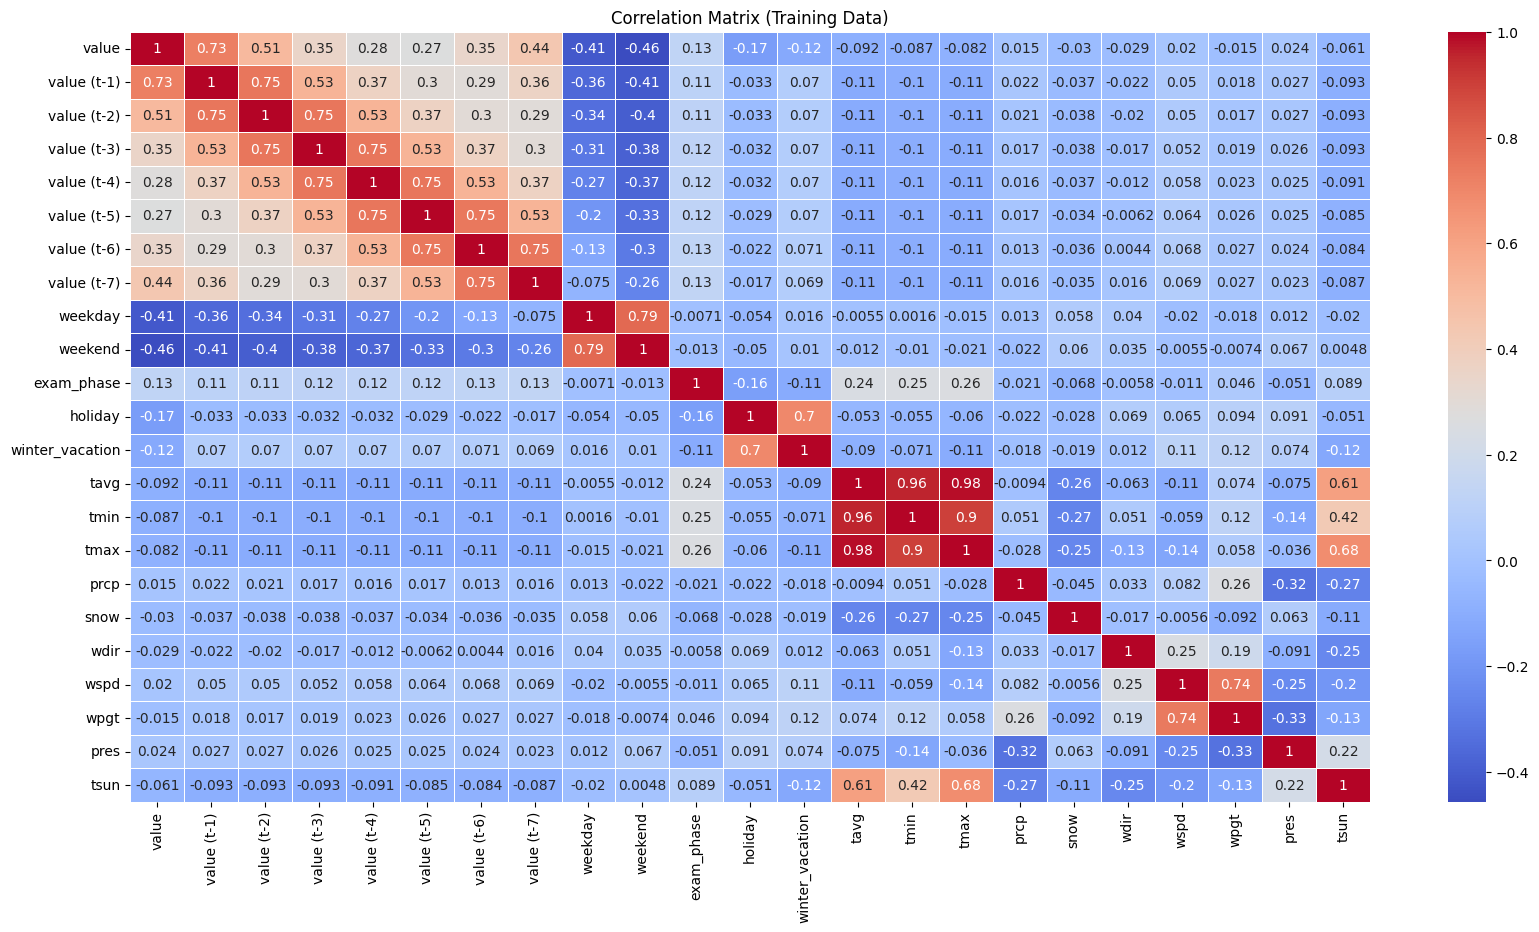

In [1249]:
# Compute the correlation matrix for all columns
correlation_matrix = visitor_data.corr()

# Create a heatmap of the entire correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix (Training Data)')
plt.show()

In [1250]:
data_corr_label = visitor_data.iloc[:, :].corr()["value"]
data_corr_label[:10]

value          1.000000
value (t-1)    0.725118
value (t-2)    0.508755
value (t-3)    0.352323
value (t-4)    0.280900
value (t-5)    0.271435
value (t-6)    0.345274
value (t-7)    0.438442
weekday       -0.412039
weekend       -0.456426
Name: value, dtype: float64

## 3. Prepare Data for Model

In [1251]:
visitor_data.shape

(4896, 24)

In [1252]:
visitor_data = visitor_data.drop('date', axis=1)
visitor_data.columns

Index(['value', 'value (t-1)', 'value (t-2)', 'value (t-3)', 'value (t-4)',
       'value (t-5)', 'value (t-6)', 'value (t-7)', 'weekday', 'weekend',
       'exam_phase', 'holiday', 'winter_vacation', 'tavg', 'tmin', 'tmax',
       'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'],
      dtype='object')

In [1253]:
# Split train- and testdata

train_data, test_data = train_test_split(visitor_data, test_size=0.2)

train_data.shape, test_data.shape

((3916, 23), (980, 23))

In [1254]:
# Split into features and labels

train_features = train_data.iloc[:, 1:]
train_labels = train_data.iloc[:, :1]

test_features = test_data.iloc[:, 1:]
test_labels = test_data.iloc[:, :1]

In [1255]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((3916, 22), (3916, 1), (980, 22), (980, 1))

In [1256]:
train_features = train_features.to_numpy()
train_labels = train_labels.to_numpy()

test_features = test_features.to_numpy()
test_labels = test_labels.to_numpy()

In [1257]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

train_features = scaler.fit_transform(train_features)
train_labels = scaler.fit_transform(train_labels)
test_features = scaler.fit_transform(test_features)
test_labels = scaler.fit_transform(test_labels)

# train_features
# train_labels
# test_features
# test_labels

# Removing the first 3 inputs for the right dimension reshape
index = [1, 2, 3]

print(train_features)
train_features = np.delete(train_features, index)
print(train_features)

[[0.2        0.2        0.2        ... 0.58367347 0.42622951 0.        ]
 [0.3        0.3        0.3        ... 0.4952381  0.50637523 0.35947712]
 [0.05       0.5        0.35       ... 0.17687075 0.49726776 0.89542484]
 ...
 [0.25       0.2        0.35       ... 0.25578231 0.69034608 0.74509804]
 [0.1        0.1        0.2        ... 0.17687075 0.49726776 0.89542484]
 [0.         0.         0.         ... 0.56326531 0.55737705 0.24183007]]
[0.2        0.2        0.2        ... 0.56326531 0.55737705 0.24183007]


In [1258]:
train_features = train_features.reshape((-1, lookback, 1))
test_features = test_features.reshape((-1, lookback, 1))

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((12307, 7, 1), (3916, 1), (3080, 7, 1), (980, 1))

In [1259]:
# Turn the data into tensors

train_features = torch.tensor(train_features).float()
train_labels = torch.tensor(train_labels).float()

test_features = torch.tensor(test_features).float()
test_labels = torch.tensor(test_labels).float()

train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

(torch.Size([12307, 7, 1]),
 torch.Size([3916, 1]),
 torch.Size([3080, 7, 1]),
 torch.Size([980, 1]))

### Dataset and DataLoader

In [1260]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(train_features, train_labels)
test_dataset = TimeSeriesDataset(test_features, test_labels)

In [1261]:
train_dataset, test_dataset

(<__main__.TimeSeriesDataset at 0x166844c6890>,
 <__main__.TimeSeriesDataset at 0x166a0c36990>)

In [1262]:
BS = 4

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

for x, y in train_loader:
    print(f"Input Batch Shape: {x.shape} - (batch size, Features, scalar label)")
    print(f"Label Batch Shape: {y.shape} - (batch size, label dimension)")
    break

Input Batch Shape: torch.Size([4, 7, 1]) - (batch size, Features, scalar label)
Label Batch Shape: torch.Size([4, 1]) - (batch size, label dimension)


## 4. Build Model

In [1263]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(LSTMModel, self).__init__()

        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (
            torch.zeros(num_layers, 1, self.hidden_layer_size),
            torch.zeros(num_layers, 1, self.hidden_layer_size),
        )

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            input_seq.view(len(input_seq), 1, -1), self.hidden_cell
        )
        predictions = self.linear(lstm_out.view(len(input_seq), -1))

        return predictions


input_size = 7
hidden_layer_size = 100

# predict a single value
output_size = 1
num_layers = 1

model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5

for epoch in range(epochs):
    # reset the hidden state at each loop
    model.hidden_cell = (
        torch.zeros(num_layers, 1, model.hidden_layer_size),
        torch.zeros(num_layers, 1, model.hidden_layer_size),
    )

    for i, (X_batch, y_batch) in enumerate(train_loader):
        # reset the gradients
        optimizer.zero_grad()

        # prevent backpropagating of the dataset
        model.hidden_cell = (
            model.hidden_cell[0].detach(),
            model.hidden_cell[1].detach(),
        )

        # forward pass
        y_pred = model(X_batch.float())

        # compute loss
        loss = loss_function(y_pred, y_batch.float())

        # backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

print("Training complete!")

# todo: fix out of bounds error

IndexError: index 3916 is out of bounds for dimension 0 with size 3916